In [5]:
import requests
import pandas as pd

In [6]:
storage_link = 'https://cloud-api.yandex.net/v1/disk/resources/download?path=/downloads/do_10_products_20190924_185230.csv'
DATA_URL = requests.get(
    storage_link, headers={'Authorization': 'OAuth AgAAAAAR9r-IAADLW_5iBR0elkbBiVj9DDsxXLU'}).json()['href']
PLOT_CONF = {'grid': False, 'figsize': (20,8), 'color': "#86bf91", 'zorder': 2}
FILE_NAME = 'products.csv'

In [7]:
with requests.get(DATA_URL, stream=True) as r:
    r.raise_for_status()

    with open(FILE_NAME, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                f.flush()

In [8]:
df = pd.read_csv(FILE_NAME, sep=';')
df['modified_time'] = pd.to_datetime(df['modified_time'], unit='s')

# Data Overview

### Rows Number

In [9]:
len(df)

108596

### Columns

In [10]:
', '.join(df.columns.sort_values())

'available, categoryId, currencyId, id, image, modified_time, name, oldprice, price, title, type, url'

 ### Categories Description

General categories sorted by ascending price mean

In [11]:
df_categories = pd.DataFrame(
    {
        'cat_name': name,
        'cat_items': len(group),
        'price_min': group['price'].min(),
        'price_mean': group['price'].mean(),
        'price_median': group['price'].median(),
        'price_max': group['price'].max()
    }
    
    for name, group in df.groupby('categoryId')
    
).sort_values('price_mean').set_index('cat_name')

df_categories.at['Total', 'cat_items'] = df_categories['cat_items'].sum() # total sum of items

df_categories

,cat_items,price_min,price_mean,price_median,price_max
cat_name,,,,,
Игрушки и Хобби,4518.0,0.06,5.675963,4.990,107.59
Часы,4510.0,0.14,5.690572,4.440,4499.10
Телефоны и Телекоммуникации,3492.0,0.18,6.186045,5.630,700.00
Автомобили и Мотоциклы,4427.0,0.04,6.603386,5.190,555.00
Компьютер & сеть,3951.0,0.05,7.030592,5.900,888.00
Бытовая электроника,2985.0,0.08,7.139742,7.400,950.00
Спорт и развлечения,3654.0,0.04,7.395758,4.790,4161.29
Ювелирные изделия и часы,3648.0,0.01,7.490079,5.090,938.00
Красота и здоровье,4660.0,0.05,8.012800,5.565,1470.00


### Overall Price Distribution 

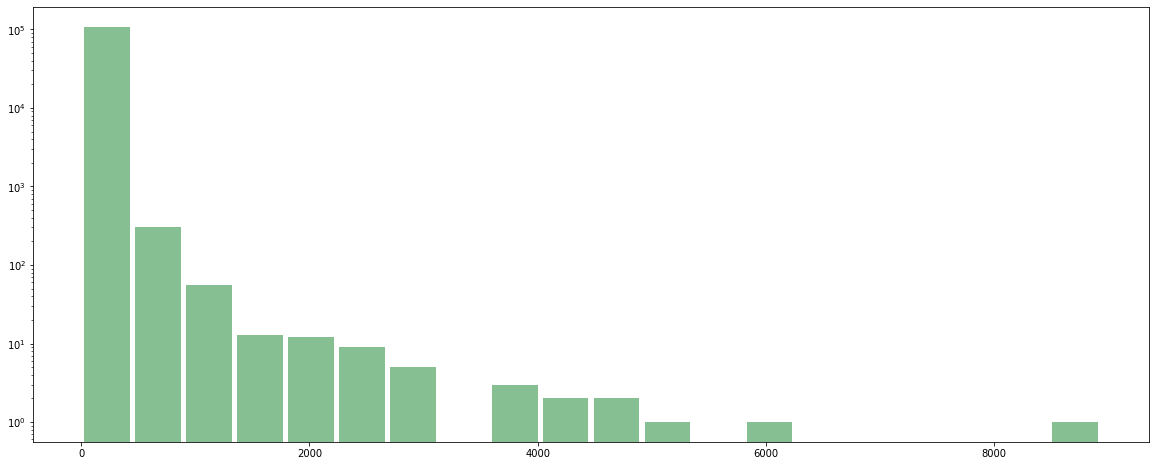

In [12]:
_ = df['price'].hist(**PLOT_CONF, log=True, bins=20, rwidth=0.9 )

### Overall Price Growth Rate
Indicates that most of the price growth falls into first month of the year, whereas at the end of year price growth
nearly zeroed.

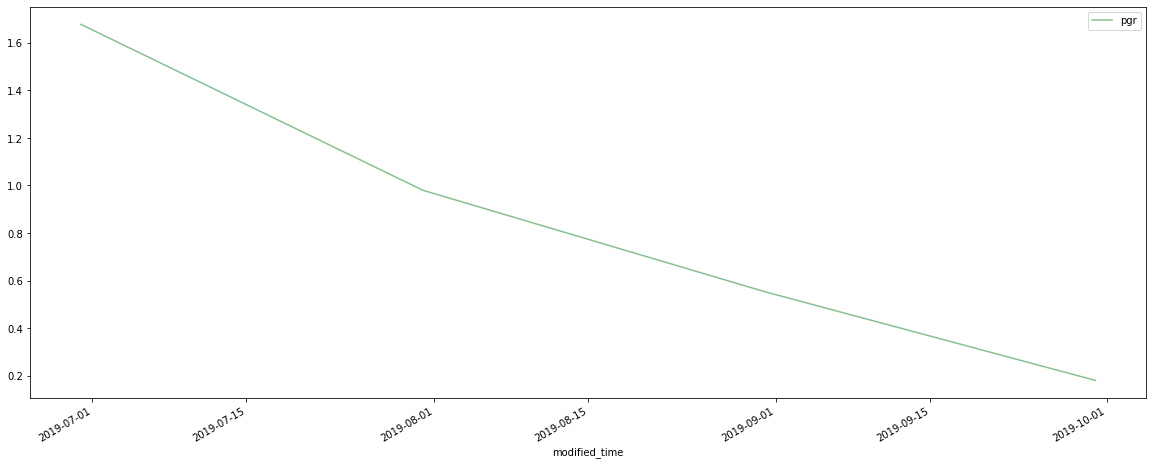

In [13]:
price_df = pd.DataFrame()
df_month_sample = df.set_index('modified_time').sort_index().resample('M').count()
price_df['pgr'] = (df_month_sample['price'] - df_month_sample['oldprice']) / df_month_sample['oldprice']
_ = price_df.dropna().plot(**PLOT_CONF)

### Categories Price Correlation

Highlights price correlation between product categories. According to data prices of categories like
 `furniture` / `beauty&health`, `Electrical equipment&materials` / `Clocks`  are positively correlated.

In [14]:
corr_df = pd.DataFrame()

for name, group in df.groupby('categoryId'):
    corr_df[name] = group.reset_index()['price']

c = corr_df.dropna().corr()

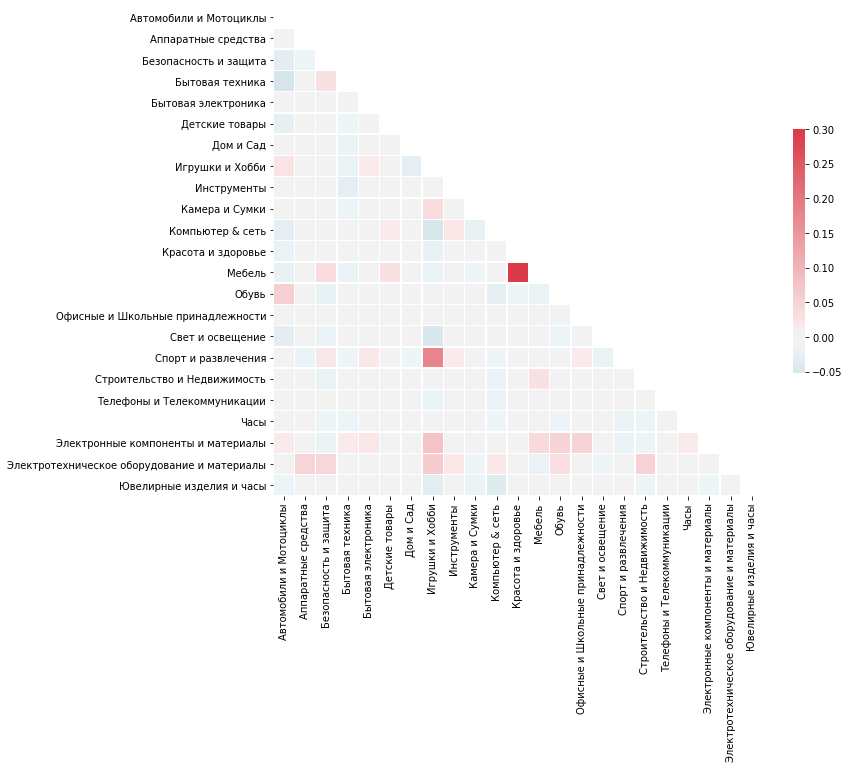

In [15]:
# Implemented in https://seaborn.pydata.org/examples/many_pairwise_correlations.html

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mask = np.triu(np.ones_like(c, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Overall Modification Time Distribution

Describes products modification time distribution. Plotted data shows that the most product changes
appeared at the end of the year.

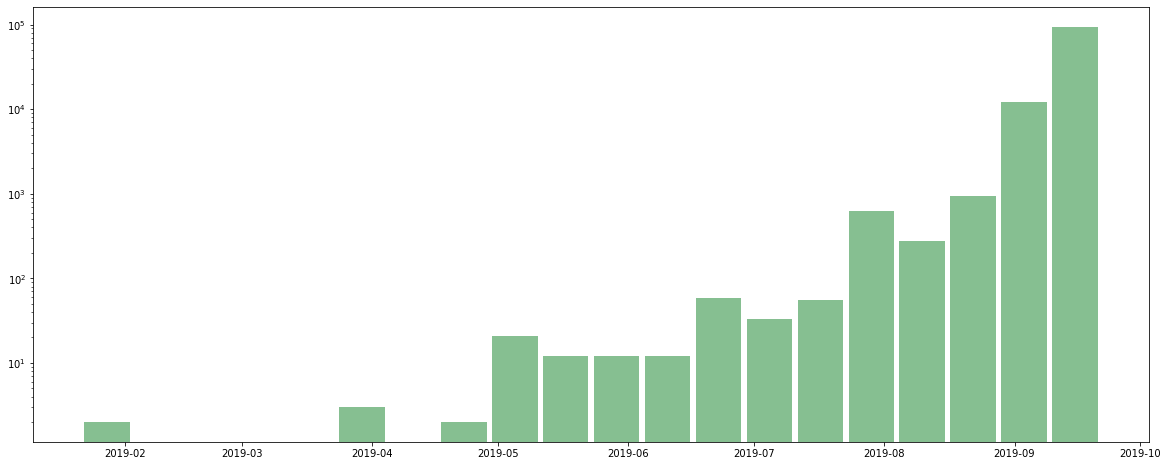

In [16]:
_ = df['modified_time'].hist(**PLOT_CONF, log=True, bins=20, rwidth=0.9)